## Demo: Classify & route community support questions from StackOverflow

![image](./images/stackoverflow.png)

## Connect to Azure Machine Learning workspace

In [1]:
import azureml.core
from azureml.core import Workspace
from init import startup
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# for reproducibility
random_state = 0 

workspace = Workspace.from_config()
print('Workspace name: ' + workspace.name, 
      'Azure region: ' + workspace.location, 
      'Subscription id: ' + workspace.subscription_id, 
      'Resource group: ' + workspace.resource_group, sep = '\n')

ds, run, hd_run, aks_service, published_pipeline, stackoverflow_dataset, raw_dataset, train, train_dataset, test_dataset = startup()

Workspace name: contoso-workspace
Azure region: westus2
Subscription id: 2a779d6f-0806-4359-a6e8-f1fd57bb5dd7
Resource group: devintersection-2018-aml-demo
SDK version: 1.7.0
demo not initialized ... to speed up demo, after you have run through demo script all the way, set the values for the Run, HD_Run and AKS Service to fetch from existing entities instead of running realtime


## It all starts with data ...
Download fresh data from StackOverflow 

> NOTE! running data download and prep steps are not needed due to being preprocessed and registered in init.py. Remove if not germane to story

![image](./images/0_data.png)

In [ ]:
! wget https://archive.org/download/stackexchange/stackoverflow.com-Posts.7z

In [ ]:
7z x stackoverflow.com-Posts.7z -oposts

### Process with PySpark (strip XML, remove answers, filter to questions already tagged (labeled)

In [ ]:
import pyspark
from pyspark.sql import functions as sf
from pyspark.sql import Row
from pyspark.sql.functions import size, col, concat_ws, rtrim, regexp_replace, split, udf
from pyspark.sql.types import ArrayType

# load xml file into spark data frame.
posts = spark.read.format("xml").option("rowTag", "row").load("./posts/Posts.xml")

# select only questions
questions = posts.filter(posts._PostTypeId == 1) 

# drop irrelvant columns and clean up strings
questions = questions.select([c for c in questions.columns if c in ['_Id','_Title','_Body','_Tags']])
questions = questions.withColumn('full_question', sf.concat(sf.col('_Title'), sf.lit(' '), sf.col('_Body')))
questions = questions.select([c for c in questions.columns if c in ['_Id','full_question','_Tags']]).withColumn("full_question", regexp_replace("full_question", "[\\n,]", " "))
questions = questions.withColumn("_Tags", regexp_replace("_Tags", "><", " "))
questions = questions.withColumn("_Tags", regexp_replace("_Tags", "(>|<)", ""))
questions = questions.withColumn('_Tags', rtrim(questions._Tags))
questions = questions.withColumn('_Tags', split(questions._Tags, " "))

# filter out to single tags in following list
tags_of_interest = ['azure-devops', 'azure-functions', 'azure-web-app-service', 'azure-storage', 'azure-virtual-machine'] 

def intersect(xs):
    xs = set(xs)
    @udf("array<string>")
    def _(ys):
        return list(xs.intersection(ys))
    return _

questions = questions.withColumn("intersect", intersect(tags_of_interest)("_Tags"))
questions = questions.filter(size(col("intersect"))==1)
questions = questions.select('_Id', 'full_question', 'intersect').withColumn('_Tags', concat_ws(', ', 'intersect'))
questions = questions.select('_Id', 'full_question', '_Tags')

### Convert processed data into Pandas data frame for final preprocessing and data split

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

df = questions.toPandas()

# drop nan values and remove line breaks
df.dropna(inplace=True)
df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

# balance dataset 
balanced = df.groupby('_Tags')
balanced.apply(lambda x: x.sample(balanced.size().min())).reset_index(drop=True).to_csv('balanced.csv')
bd = pd.read_csv('balanced.csv')
bd.drop('Unnamed: 0', axis=1, inplace=True)

# shuffle data 
bd = shuffle(bd)

# split data into train, test, and valid sets
msk = np.random.rand(len(bd)) < 0.7
train = bd[msk]
temp = bd[~msk]
msk = np.random.rand(len(temp)) < 0.66
valid = temp[msk]
test = temp[~msk]

In [9]:
train.head(10)

,ID,IssueTitle,Label
0,52821204,How to queue build pipeline as task from release pipeline? <p>There is a build pipeline that someone else owns in th...,azure-devops
1,52818615,"Unable to download the change history and the discussion details of \Scrum tasks\"" in VSTS using odata <p>I don't ex...",azure-devops
2,55840501,Is FileUpload functionality for Azure IoT Java SDK possible on Android? <p>We've been trying to use the Azure IoT SD...,azure-storage
3,29638084,Error Calling InitializeCache on WindowsAzure Storage Account <p>I have the following snippet being called on on app...,azure-storage
4,56484241,AZURE_FUNCTIONS_ENVIRONMENT vs ASPNETCORE_ENVIRONMENT <p>In azure functions (v2 c#) there are two environment vari...,azure-functions
5,15122998,Azure Blob Shared Access Signature without the api <p>I'm trying to create a REST call to Azure to List Blobs within...,azure-storage
6,39381114,Azure Webapp wheels --find-links does not work <p>I have been struggling with --find-links for an entire day and I ...,azure-web-app-service
7,55574037,Access denied on wwwroot after DevOps deployment <p>I've deployed a .Net Core web application to Azure App Service u...,azure-devops
8,53532538,Running an Azure DevOps pipline via CLI or web-hook <p>Is there a way to run (queue) a specific azure pipeline from ...,azure-devops
9,50077386,How to dynamically define 'path' in @BlobOutput? <p>I am looking at the following code example at <a href=\https://g...,azure-functions


### Profile data for class imbalance to avoid bias, missing values, etc

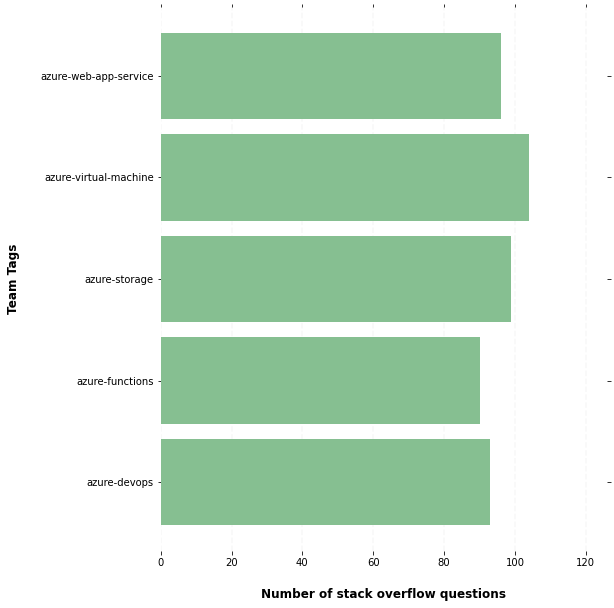

In [2]:
x = train.groupby('Label')['IssueTitle'].count()
ax = x.plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks, Draw vertical axis lines, Set axis labels
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
vals = ax.get_xticks()

for tick in vals:
  ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Number of stack overflow questions", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Team Tags", labelpad=20, weight='bold', size=12)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [3]:
from pandas_profiling import ProfileReport
prof = ProfileReport(train) 

In [4]:
prof.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

,ID,IssueTitle,Label
0,52821204,How to queue build pipeline as task from release pipeline? <p>There is a build pipeline that someone else owns in th...,azure-devops
1,52818615,"Unable to download the change history and the discussion details of \Scrum tasks\"" in VSTS using odata <p>I don't ex...",azure-devops
2,55840501,Is FileUpload functionality for Azure IoT Java SDK possible on Android? <p>We've been trying to use the Azure IoT SD...,azure-storage
3,29638084,Error Calling InitializeCache on WindowsAzure Storage Account <p>I have the following snippet being called on on app...,azure-storage
4,56484241,AZURE_FUNCTIONS_ENVIRONMENT vs ASPNETCORE_ENVIRONMENT <p>In azure functions (v2 c#) there are two environment vari...,azure-functions
5,15122998,Azure Blob Shared Access Signature without the api <p>I'm trying to create a REST call to Azure to List Blobs within...,azure-storage
6,39381114,Azure Webapp wheels --find-links does not work <p>I have been struggling with --find-links for an entire day and I ...,azure-web-app-service
7,55574037,Access denied on wwwroot after DevOps deployment <p>I've deployed a .Net Core web application to Azure App Service u...,azure-devops
8,53532538,Running an Azure DevOps pipline via CLI or web-hook <p>Is there a way to run (queue) a specific azure pipeline from ...,azure-devops
9,50077386,How to dynamically define 'path' in @BlobOutput? <p>I am looking at the following code example at <a href=\https://g...,azure-functions


,ID,IssueTitle,Label
472,50340216,ListBlobsSegmentedAsync doesn't return all blob directories <p>I have a hierarchy-structured blob container with aro...,azure-storage
473,31513870,Azure Website Logs Including Internal IPs in Entries <p>For the last couple of weeks we have been seeing an increas...,azure-web-app-service
474,57332314,reading content of blob from azure function <p>I'm trying to read the content of a blob inside an azure function.</p...,azure-functions
475,57613198,UrlHelper returning http links on Azure App Service <p>I have a service that when deployed on Azure App Services ret...,azure-web-app-service
476,41380707,Any way to upload file to azure virtual machine from external application <p>I have a windows application and I want...,azure-virtual-machine
477,50225208,Export from Azure Storage Queue to a CSV file <p>What is the easiest way to export data from Azure Queue to a <em>CS...,azure-storage
478,40852776,Why is docker stats CPU Percentage greater than 100 times number of cores <p>I have an Azure VM with 2 cores. From m...,azure-virtual-machine
479,50807409,Many 4 character storage containers being created in my storage account <p>I have an Azure storage account. </p> <p...,azure-storage
480,13995734,Azure VMs Virtual Network inter-communication <p>I'm new to Azure (strike 1) and totally suck at networking (strike ...,azure-virtual-machine
481,54008309,Azure functions local.settings.json represented in appsettings.json for a ServiceBusTrigger <p>I currently have an a...,azure-functions


Render widgets: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

### Estimate predictive power using KMeans clustering, TF-IDF) & PCA 

In [7]:
#Feature extraction, we’ll compute TF-IDF values.
vec = TfidfVectorizer(stop_words="english")
vec.fit(train.IssueTitle.values)
features = vec.transform(train.IssueTitle.values)

# Let’s create an instance of KMeans, issues that belong to one of 4 categories
cls = MiniBatchKMeans(n_clusters=4, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=3, random_state=0, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

Homogeneity:0.20006085079688235


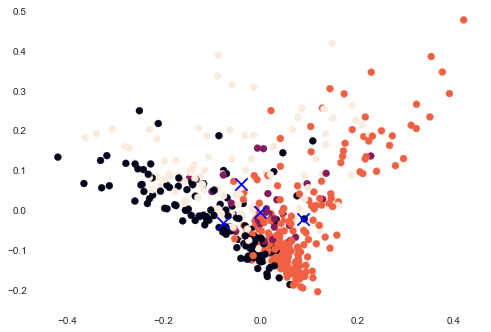

In [9]:
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

from sklearn.metrics import homogeneity_score
homogeneity = homogeneity_score(train.IssueTitle, cls.predict(features))
print('Homogeneity:' + str(homogeneity))

## BERT to the rescue: Fine-tune deep learning NLP model with Azure ML

![image](./images/1_train.png)

BERT is a very large network with multiple layers of Transformers (12 for BERT-base, and 24 for BERT-large). The model is first pre-trained on large corpus of text data (WikiPedia + books) using un-superwised training (predicting masked words in a sentence). During pre-training the model absorbs significant level of language understanding.

Pre-trained network then can easily be fine-tuned to solve specific language task, like answering questions, or categorizing spam emails.

<img src="http://jalammar.github.io/images/bert-classifier.png" alt="Drawing" style="width: 700px;"/>

## Create Compute Target

A [compute target](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.computetarget?view=azure-ml-py) is a designated compute resource/environment where you run your training script or host your service deployment. This location may be your local machine or a cloud-based compute resource. Compute targets can be reused across the workspace for different runs and experiments. 

In [12]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = 'gpu-cluster'

try:
    compute_target = ComputeTarget(workspace=workspace, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC12s_v3', 
                                                           vm_priority='lowpriority',
                                                           idle_seconds_before_scaledown=6000,
                                                           min_nodes=0, 
                                                           max_nodes=2)

    compute_target = ComputeTarget.create(workspace, cluster_name, compute_config)
    compute_target.wait_for_completion(show_output=True)

Found existing compute target.


## Perform Experiment

Now that we have our compute target, dataset, and training script, it is time to scale up so that the script can run faster. We will start by creating an [experiment](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.experiment.experiment?view=azure-ml-py). An experiment is a grouping of many runs from a specified script. All runs in this tutorial will be performed under the same experiment. 

In [11]:
from azureml.core import Experiment

experiment_name = 'azure-stackoverflow-classifier' 
experiment = Experiment(workspace, name=experiment_name)

### Distributed Training Across Multiple GPUs

Distributed training allows us to train across multiple nodes if your cluster allows it. Azure Machine Learning service helps manage the infrastructure for training distributed jobs. All we have to do is add the following parameters to our estimator object in order to enable this:

#### 1) Create TensorFlow Estimator

The Azure Machine Learning Python SDK Estimator classes allow you to easily construct run configurations for your experiments. They allow you too define parameters such as the training script to run, the compute target to run it on, framework versions, additional package requirements, etc. 

#### 2) Add Metrics Logging in your training script

So we were able to clone a Tensorflow 2.0 project and run it without any changes. However, with larger scale projects we would want to log some metrics in order to make it easier to monitor the performance of our model. 

We can do this by adding a few lines of code into our training script:

```python
from azureml.core.run import Run
run = Run.get_context()
run.log('val_accuracy', float(logs.get('val_accuracy')))
run.log('accuracy', float(logs.get('accuracy')))
```

In [120]:
f = open("./code/train_horovod.py", "r", encoding="utf-8")
print(f.read())

import os
import argparse
import logging
import pandas as pd
import tensorflow as tf
import horovod.tensorflow.keras as hvd
from absl import app
from absl import flags
from transformers import BertTokenizer
from model import TFBertForMultiClassification
from azureml.core.run import Run
import tempfile

# Ignore warnings in logs
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

# Get the Azure ML run object
run = Run.get_context()

# Define input arguments
FLAGS = flags.FLAGS
flags.DEFINE_integer('max_seq_length', 128, 'Maximum sequence length of input sentences.')
flags.DEFINE_integer('batch_size', 32, 'Batch size for training.', lower_bound=0)
flags.DEFINE_float('learning_rate', 3e-5, 'Learning rate for training.')
flags.DEFINE_integer('steps_per_epoch', 150, 'Number of steps per epoch.')
flags.DEFINE_integer('num_epochs', 3, 'Number of epochs to train for.', lower_bound=0)
flags.DEFINE_string('data_dir', None, 'Root path of directory where data is stored.'

In [13]:
from azureml.train.dnn import TensorFlow, Mpi

estimator = TensorFlow(source_directory='./code',
                        entry_script='train_horovod.py',
                        compute_target=compute_target,
                        script_params = {
                              '--data_dir': stackoverflow_dataset.as_named_input('stackoverflow_dataset').as_mount(),
                              '--max_seq_length': 128,
                              '--batch_size': 32,
                              '--learning_rate': 3e-5,
                              '--steps_per_epoch': 150,
                              '--num_epochs': 3,
                              '--export_dir':'./outputs/model'
                        },
                        framework_version='2.0',
                        node_count=1,
                        distributed_training=Mpi(process_count_per_node=2),
                        use_gpu=True,
                        pip_packages=['transformers==2.0.0'])

In [14]:
run = experiment.submit(estimator)

In [15]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Tune Hyperparameters Using Hyperdrive

So far we have been putting in default hyperparameter values, but in practice we would need tune these values to optimize the performance. Azure Machine Learning service provides many methods for tuning hyperparameters using different strategies.

In [16]:
from azureml.train.hyperdrive import HyperDriveConfig, BanditPolicy, PrimaryMetricGoal, GridParameterSampling
from azureml.train.hyperdrive.parameter_expressions import choice

param_sampling = GridParameterSampling( {
        '--learning_rate': choice(3e-5, 3e-4),
        '--num_epochs': choice(3, 4)
    }
)

primary_metric_name='val_accuracy'
primary_metric_goal=PrimaryMetricGoal.MAXIMIZE

early_termination_policy = BanditPolicy(slack_factor = 0.1, evaluation_interval=1, delay_evaluation=2)

hd_estimator = TensorFlow(source_directory='./code',
                        entry_script='train_logging.py',
                        compute_target=compute_target,
                        script_params = {
                              '--data_dir': stackoverflow_dataset.as_named_input('stackoverflow').as_mount(),
                              '--max_seq_length': 128,
                              '--batch_size': 32,
                              '--steps_per_epoch': 150,
                              '--export_dir':'./outputs/model',
                        },
                        framework_version='2.0',
                        use_gpu=True,
                        pip_packages=['transformers==2.0.0'])

hyperdrive_run_config = HyperDriveConfig(estimator=hd_estimator,
                                         hyperparameter_sampling=param_sampling, 
                                         policy=early_termination_policy,
                                         primary_metric_name=primary_metric_name, 
                                         primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                         max_total_runs=10,
                                         max_concurrent_runs=2)

In [17]:
hd_run = experiment.submit(hyperdrive_run_config)

When we view the details of our run this time, we will see information and metrics for every run in our hyperparameter tuning.

In [18]:
from azureml.widgets import RunDetails
RunDetails(hd_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

We can retrieve the best run based on our defined metric.

In [19]:
best_run = hd_run.get_best_run_by_primary_metric()

## Register Model

A registered [model](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model(class)?view=azure-ml-py) is a reference to the directory or file that make up your model. After registering a model, you and other people in your workspace can easily gain access to and deploy your model without having to run the training script again. 

Let's register the best run from our hyperparameter tuning.

In [20]:
model = best_run.register_model(model_name='azure-service-classifier', 
                                model_path='./outputs/model',
                                datasets=[('train, test, validation data', stackoverflow_dataset)],
                                description='BERT model for classifying azure services on stackoverflow posts.')

## Deploy models using Azure ML
Now we are ready to deploy the model as a web service running on your [local](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where#local) machine, in Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/) or Azure Kubernetes Service [AKS](https://azure.microsoft.com/en-us/services/kubernetes-service/). Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in. 

![image](./images/2_deploy.png)

In [21]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.model import InferenceConfig, Model
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import AksWebservice, Webservice

### Create Inference config and environment dependencies

In [ ]:
f = open("./code/score.py", "r", encoding="utf-8")
print(f.read())

In [22]:
aks_target = AksCompute(workspace,"contoso-aks")

myenv = CondaDependencies.create(conda_packages=['numpy','pandas'],
                                 pip_packages=['numpy','pandas','inference-schema[numpy-support]','azureml-defaults','tensorflow==2.0.0','transformers==2.0.0'])

with open("./code/myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

deployment_config = AksWebservice.deploy_configuration(cpu_cores = 2, memory_gb = 4)
inference_config = InferenceConfig(source_directory="./code",
                                   runtime= "python", 
                                   entry_script="score.py",
                                   conda_file="myenv.yml"
                                  )

### Deploy model

In [23]:
aks_service = Model.deploy(workspace, "stackoverflow-classifier", [model], inference_config, deployment_config, aks_target)

### Get the AML generated REST API

In [32]:
import json
import requests

scoring_uri = aks_service.scoring_uri

key, secondary_key = aks_service.get_keys()
print(scoring_uri)

http://13.90.172.141:80/api/v1/service/stackoverflow-classifier/score


### Test the model!

In [30]:
def predict(text):
    input_data = json.dumps({'text': text})

    #prediction = aks_service.run(input_data=raw_data)
    #print(prediction)

    # Set the content type
    headers = {'Content-Type': 'application/json'}
    # If authentication is enabled, set the authorization header
    headers['Authorization'] = f'Bearer {key}'

    # Make the request and display the response
    return (requests.post(scoring_uri, input_data, headers=headers)).text

In [110]:
tests = ("What happens if multiple azure function apps bind to the same storage queue for input <p>I have function apps running in two different regions for redundancy. i.e. there are two separate apps in azure portal (deployed from the same code). So both apps have the function that input binds to the same storage queue. Would all messages be delivered to both or would the messages get split between the two?</p>  <p>I am using C#  dotnet core  and Functions 2.0.</p>",
"Linking an existing repository to Visual Studio Team Services repository (Github to VSTS migration) <p>We are currently in the process of moving all of our repositories over to VSTS from Github which has been great and easy so far but are now running into the small problem of linking our old local repositories to the new ones in VSTS.</p>  <p>So technically they should be the exact same files except for the local ones that we weren't committing up to Github in the first place (Which we'd like to not have to manually copy back and forth). Is there a way to link these local repositories to the new ones in VSTS?</p>",
"Host name and port for Python Websockets on Azure Web Apps <p>Spoiler  I am quite new to this. So my question might be stupid.</p>  <p>Anyways  I am currently using the 'Websockets' API for Python 3.5 in a project that will be hosted on a Azure Web App. When creating the Websocket server using <code>websockets.serve(WS_HANDLER  HOST  PORT)</code> I want to specify the host somehow. For envelopment I just set it as localhost with port 8xxx  but I am struggling to know which <code>HOST</code> and <code>PORT</code> to use in production/deployment. I assume that you can access the <code>HOST</code> via som OS variable  but I can't find any information regarding it. Or is all of this handled by the <code>web.config</code> file?</p>",
"How can I clear nuget cache in Azure Functions <p>How can I clear nuget cache in Azure Functions? Some changes happend to our nuget package but version wasn't changed. (The package in dev now  and we can't change the version now  it should be the same) </p>",
"Can an app targeting .net framework 4.7.2 be safely run on .net framework 4.7.1? <p>I have this issue in which I'm currently targeting .NET Framework 4.7.2 in my solution but the Azure Web App Service only supports up to .NET Framework 4.7.1.  So  my question is this:  As long as I only use 4.7.1 features  should it work without issue on the Azure Web App Service (which only supports up to 4.7.1) even though I'm targeting 4.7.2?  Are the .NET Frameworks backwards compatible?  So far  I haven't seen any issues.  I just want to make sure there will be no future complications.  Ideally  I would like to keep targeting 4.7.2 so that I can start using the 4.7.2 features once it becomes available on Azure Web App Service.</p>",
"Azure Application gateway with web apps <p>I have setup a Azure Application Gateway in front of an Azure Web Application. I have added a IP restriction on Web app allowing access only from the Application gateway's public IP address. This works fine but the when I add the public IP address on the browser it re-directs to the web app's URL. How can I stop the application gateway redirecting to the web app URL but to return the response against the public IP?</p>",
"Azure SQL web server - virtual machine   server agent stops it self and so the jobs scheduled <p>With using Windows Azure SQL web server - virtual machine   I have small size SQL web server - VM for multiple databases.</p>  <p>I have noticed that server agent stops it self some how   and so the scheduled jobs were not executed on time.</p>  <p>Any solution / suggestion on this ? </p>",
"Can Atlassian read/copy my source code by using SourceTree <p>I have a question: </p>  <p>Will our code pass through Atlassian servers when I use <strong>SourceTree</strong> in combination with <strong>Visual Studio Online</strong>. I added my <strong>access token</strong> to the git repository connection string in SourceTree. Will the SourceTree application download direct or will it read my code and maybe keep a back-up somewhere or pass it through Atlassian Servers.</p>  <p>This question is because we do not want other companies to read our code at this moment. Is it safe to use SourceTree at this time with the above in mind?</p>",
"Migrating on-premise TFS 2012 to VSO with free opshub tool <p>We are moving from on-premise tfs 2012 to the visual studio online environment. For this we need to move a lot of projects  most of them arenâ€™t a problem with the free opshub tool.</p>  <p>But 2 of our projects are really big and the tool would take about 8~9 days to complete the migration  which is too long for us.</p>  <p>What I would like is the following:</p>  <ul> <li>Start the migration from on-premise to vso </li> <li>Keep working in the on-premise  </li> <li>After the migration has finished  migrating the commits that were made in the last 8~9 days.</li> </ul>  <p>Iâ€™m not sure the free opshub tool supports something like this. Is there a way to do this with the free tool? If so how does this work?</p>",
"Not able to load Microsoft.WindowsAzure.ServiceRuntime  Version=1.8.0.0  ............. Local works fine <p>After publishing the cloud based application (web role) from visual studio  application gives following error on accessing the landing page.</p>  <p>Could not load file or assembly 'Microsoft.WindowsAzure.ServiceRuntime  Version=1.8.0.0  Culture=neutral  PublicKeyToken=31bf3856ad364e35' or one of its dependencies. The system cannot find the file specified.</p>  <p>Locally the same application works fine. I have kept the reference of Microsoft.WindowsAzure.ServiceRuntime Copy Local attribute to True in its property while publishing the site. </p>  <p>I am using AzureSDK 2.0 and have reference of all storage services of version 2.0 in the reference folder.</p>  <p>I also have following in my web.config file.                           </p>  <p>Still am getting the above error. Please suggest how to solve the issue. </p>",
"Removing yourself from Visual Studio Team Services Accounts <p>On my visualstudio.com dashboard it says I am a member to a Team Service Account. How can I remove myself? The project is long done and I don't want to see that anymore. I am not the owner and cannot contact him.</p>",
"Azure Storage Queue - long time to process <p>I need to generate quite a number of reports and a report can take about 5 minutes to be generated  large amount of data  many different sources.</p>  <p>The client will post messages to an Azure Storage Queue. There is a worker roles that processes the messages and generates the reports.</p>  <p>If I want to scale this up let's say I end up with 10 worker roles that will process the messages from the queue and generate the reports. Then I will add messages into the queue like this:</p>  <ul> <li>message 1: process reports from 1 - 5</li> <li>message 2: process reports from 6 - 11 ........</li> <li>message 10: process reports from 50 - 55 (might not be accurate the range)</li> </ul>  <p>If my worker role 1 will take the first message and put a lock on it but the process will take 5 minutes  the lock will expire and the message will be visible again in the queue so the worker role 2 will take it and start processing it ... and so forth </p>  <p>How can I avoid that consuming the queue message is done only once keeping in mind that the task is a long one?</p>",
"Azure Functions Consumption plan failover <p>If you're using Consumption plan for Azure Functions is there any kind of failover if your region goes down or hardware failure occurs? Hardware failure I'd assume yes  but for a region it doesn't seem like it since you can only choose one.</p>  <p>So if we really need multi-region failover are we limited to using App Service plan for Functions?</p>",
"How to run a remote Powershell in VSTS release only if script exists? <p>In VSTS release management there is a nice remote Powershell task where we can run a script on the target machine. However I'd need a way to tell the release managment that only run this file if it exists  otherwise silently ignore that.</p>  <p>I know I can configure a task to not block the process in case of error  however in that case there still will be an exclamation mark in the log and the deployment will get the partial succeeded status. I'd like to avoid this and show success even if the file doesn't exist.</p>  <p>With this I need it to support kind of optional setup scripts for several deployed products.</p>",
"SQL Server Database to share with team? <p>I'm looking for a method to share SQL Server Database's structures and their contents/datas with the team? We're currently using TFS 2013. If it's the case we can switch to SVN/GIT etc  too.</p>  <p>Thanks in advance.</p>",
"SQL Server on Azure VM Slow Network <p>I'm running  SQL Server on Azure VM (Size DS_15).  The server is extremely fast.  My queries are extremely fast.</p>  <p>When I run my application (it's legacy VB 6) from another Azure VM it's extremely fast.  When I run the same application and same identical queries from outside of the Azure DataCenter it's at least 10-15 seconds slower.  I'm using ODBC Data Sources (again  it's legacy) but can't seem to do anything to speed up the connections.</p>  <p>When the slow connections are running SQL Profiler just spits out the same extremely fast data points.  I'm struggling to find where to look next to try to speed these connections up?</p>  <p>When I run some of the trouble queries manually in SSMS with STATS on they return in 0  0  and 4 ms.  The same queries when ran through the app are taking 140  130  and 280ms.</p>",
)

predictions = []
for test in tests:
    prediction = json.loads(predict(test))
    prediction['input'] = test
    predictions.append(prediction)

test_results= pd.DataFrame.from_dict(predictions)
test_results

,prediction,probability,input
0,azure-functions,0.99683726,What happens if multiple azure function apps bind to the same storage queue for input <p>I have function apps runnin...
1,azure-devops,0.9962333,Linking an existing repository to Visual Studio Team Services repository (Github to VSTS migration) <p>We are curren...
2,azure-web-app-service,0.9839443,Host name and port for Python Websockets on Azure Web Apps <p>Spoiler I am quite new to this. So my question might ...
3,azure-functions,0.99726486,How can I clear nuget cache in Azure Functions <p>How can I clear nuget cache in Azure Functions? Some changes happe...
4,azure-web-app-service,0.9888576,Can an app targeting .net framework 4.7.2 be safely run on .net framework 4.7.1? <p>I have this issue in which I'm c...
5,azure-web-app-service,0.9892532,Azure Application gateway with web apps <p>I have setup a Azure Application Gateway in front of an Azure Web Applica...
6,azure-virtual-machine,0.9806002,Azure SQL web server - virtual machine server agent stops it self and so the jobs scheduled <p>With using Windows ...
7,azure-devops,0.9928422,Can Atlassian read/copy my source code by using SourceTree <p>I have a question: </p> <p>Will our code pass through...
8,azure-devops,0.9932981,Migrating on-premise TFS 2012 to VSO with free opshub tool <p>We are moving from on-premise tfs 2012 to the visual s...
9,azure-storage,0.98742104,Not able to load Microsoft.WindowsAzure.ServiceRuntime Version=1.8.0.0 ............. Local works fine <p>After pub...


## Create AML Pipeline to enable repeating the process
Full end to end process includes not just model training but also data prep and model validation

In [24]:
cpu_compute_target = workspace.compute_targets['cpu-cluster']

In [25]:
from azureml.core import Workspace, Dataset, Datastore, ComputeTarget, RunConfiguration, Experiment
from azureml.core.runconfig import CondaDependencies

conda = CondaDependencies.create(
        pip_packages=['azureml-sdk'],
        pin_sdk_version=False)

conda.set_pip_option('--pre')

run_config = RunConfiguration()
run_config.environment.python.conda_dependencies = conda

In [26]:
from azureml.data.data_reference import DataReference
from azureml.pipeline.steps import HyperDriveStep, HyperDriveStepRun, PythonScriptStep
from azureml.pipeline.core import Pipeline, PipelineData

data_folder = DataReference(
    datastore=ds,
    data_reference_name="new_updated_stackoverflow_data")

In [27]:
tf_est = TensorFlow(source_directory='./code',
                        entry_script='train_logging.py',
                        compute_target=compute_target,
                        framework_version='2.0',
                        use_gpu=True,
                        pip_packages=['transformers==2.0.0'])

In [28]:
hd_config = HyperDriveConfig(estimator=tf_est,
                                         hyperparameter_sampling=param_sampling, 
                                         policy=early_termination_policy,
                                         primary_metric_name=primary_metric_name, 
                                         primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                         max_total_runs=10,
                                         max_concurrent_runs=2)

In [29]:
prepared_stackoverflow_data = PipelineData('prepared_stackoverflow_data', datastore=ds)

# register output data as dataset
prep_step = PythonScriptStep(name='prep_data',
                             script_name="./code/prepare.py",
                             inputs=[data_folder],
                             outputs=[prepared_stackoverflow_data],
                             compute_target=cpu_compute_target,
                             runconfig=run_config)

In [30]:

metrics_data = PipelineData(name='metrics_data', datastore=ds, pipeline_output_name='metrics_output')

hd_step = HyperDriveStep(
    name='train_model_hyperparameter_sweep',
    hyperdrive_config=hd_config,
    estimator_entry_script_arguments=['--data_dir', stackoverflow_dataset.as_named_input('stackoverflow_data').as_download(),
                 '--max_seq_length', '128',
                 '--batch_size','32',
                 '--steps_per_epoch', '150',
                 '--export_dir', './outputs/model'
                ],
    inputs=[prepared_stackoverflow_data],
    metrics_output=metrics_data)

In [31]:
validation_results = PipelineData(name='validation_results', datastore=ds, pipeline_output_name='validation_results')

validate_model = PythonScriptStep(name='validate_model_quality',
                             inputs=[],
                             outputs=[validation_results],     
                             script_name="./code/validate.py",
                             compute_target=cpu_compute_target)

In [32]:
model_data = PipelineData(name='best_model', datastore=ds, pipeline_output_name='model_output')

register_model = PythonScriptStep(name='register_model',
                             inputs=[validation_results],
                             outputs=[model_data],     
                             script_name="./code/register.py",
                             compute_target=cpu_compute_target)

In [33]:
register_model.run_after(validate_model)
validate_model.run_after(hd_step)
hd_step.run_after(prep_step)

In [34]:
pipeline = Pipeline(workspace, steps=[register_model])

In [35]:
published_pipeline = pipeline.publish(name="Train BERT-based Classifier for StackOverFlow Azure Issues", description="Prep new data, train and automate hyperparameter sweep then register best model", continue_on_step_failure=True)

Created step register_model [a2a684a5][ca35bfc9-2aa7-4160-9be3-e53702b5a5e7], (This step will run and generate new outputs)
Created step validate_model_quality [31f51a66][9a4f5651-9e5b-4b54-8cc3-28a9aaff0eab], (This step will run and generate new outputs)
Created step train_model_hyperparameter_sweep [6012ead9][16b7cff9-c674-4b54-b817-d4c060f7f906], (This step will run and generate new outputs)
Created step prep_data [a8b7904e][5851e2a2-2b71-460e-aa64-deed4bff17a4], (This step will run and generate new outputs)
Created data reference new_updated_stackoverflow_data for StepId [4ab11f88][bb159d8d-1f40-41e5-ab43-fb355a81ae15], (Consumers of this data will generate new runs.)


In [36]:
pipeline_run = experiment.submit(published_pipeline)

Submitted PipelineRun 9c2f6947-dd02-4aad-9fca-11d4afefbb5d
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/azure-stackoverflow-classifier/runs/9c2f6947-dd02-4aad-9fca-11d4afefbb5d?wsid=/subscriptions/2a779d6f-0806-4359-a6e8-f1fd57bb5dd7/resourcegroups/devintersection-2018-aml-demo/workspaces/contoso-workspace
